In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Simple portfolio sorts

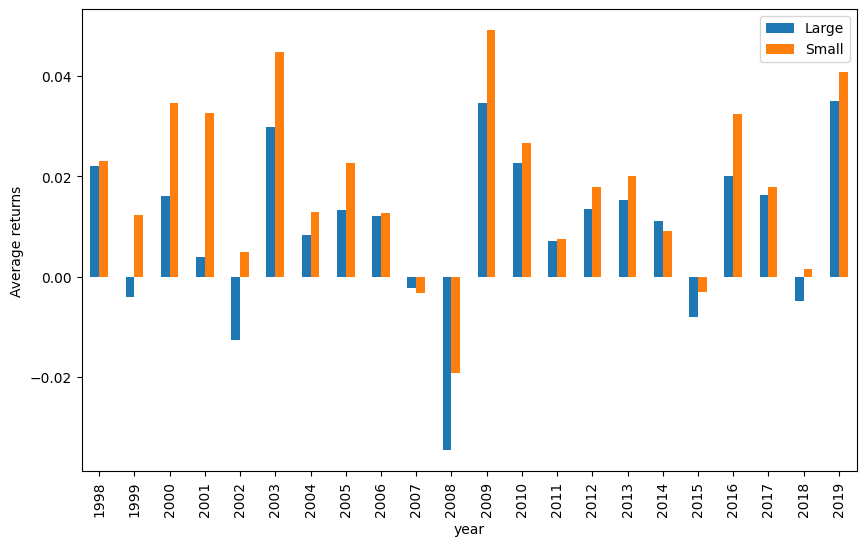

In [4]:

data_ml = pd.read_csv('/content/data_ml.csv')

_median = data_ml[["date", "Mkt_Cap_12M_Usd"]].groupby(["date"]).median().reset_index()
_median.rename(columns = {'Mkt_Cap_12M_Usd': 'cap_median'}, inplace = True)
data_tmp = pd.merge(data_ml[["date", "R1M_Usd", "Mkt_Cap_12M_Usd"]], _median,
                    how = "left", on = ["date"])
data_tmp["large"] = np.where(data_tmp["Mkt_Cap_12M_Usd"] > data_tmp["cap_median"], "Large", "Small")
data_tmp["year"] = pd.to_datetime(data_tmp['date']).dt.year
data_tmp = data_tmp.groupby(["year", "large"])["R1M_Usd"].mean().unstack()
data_tmp.loc[:, ["Large", "Small"]].plot.bar(figsize = (10, 6));
plt.ylabel('Average returns')
plt.xlabel('year')
plt.legend(loc = "best");

# Ken French’s data library

In [7]:
import urllib.request
import zipfile
import datetime

# download and unzip
min_date = '1963-07-31'
max_date = '2020-03-01'
ff_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_CSV.zip"
urllib.request.urlretrieve(ff_url,"factors.zip")
file = zipfile.ZipFile("factors.zip")
file.extractall()
file.close()

In [37]:
import pandas as pd
import datetime


df_ff = pd.read_csv('/content/F-F_Research_Data_5_Factors_2x3 (1).csv', header=2, index_col=0,sep=',', quotechar='"')

# Standardize column names
df_ff.rename(columns={'Mkt-RF': 'MKT_RF'}, inplace=True)
# KEEP DATA UNTIL 202003
df_ff = df_ff.loc[:'202003', :]

# Convert ONLY numeric factor columns
factor_cols = ['MKT_RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
df_ff[factor_cols] = df_ff[factor_cols].apply(pd.to_numeric, errors='coerce')

# Convert % to decimals
df_ff[factor_cols] = df_ff[factor_cols] / 100.0

# PROCESS DATE COLUMN

# Convert index YYYYMM → datetime
df_ff['date'] = pd.to_datetime(df_ff.index.astype(str), format="%Y%m")

# Convert month-start → month-end
df_ff['date'] = df_ff['date'] + pd.offsets.MonthEnd(0)

# Store date as string 'YYYY-MM-DD'
df_ff['date'] = df_ff['date'].dt.strftime('%Y-%m-%d')

# Add year column
df_ff['year'] = pd.to_datetime(df_ff['date']).dt.year

# Reset index
df_ff.reset_index(drop=True, inplace=True)

# 5. FILTER BETWEEN min_date & max_date
# (Define min_date & max_date before running)
idx_ff = (df_ff['date'] >= min_date) & (df_ff['date'] <= max_date)

FF_factors = df_ff.loc[idx_ff, :]
FF_factors.head()


,MKT_RF,SMB,HML,RMW,CMA,RF,date,year
0,-0.0039,-0.0044,-0.0089,0.0068,-0.0123,0.0027,1963-07-31,1963
1,0.0507,-0.0075,0.0168,0.0036,-0.0034,0.0025,1963-08-31,1963
2,-0.0157,-0.0055,0.0008,-0.0071,0.0029,0.0027,1963-09-30,1963
3,0.0253,-0.0137,-0.0014,0.0280,-0.0202,0.0029,1963-10-31,1963
4,-0.0085,-0.0089,0.0181,-0.0051,0.0231,0.0027,1963-11-30,1963


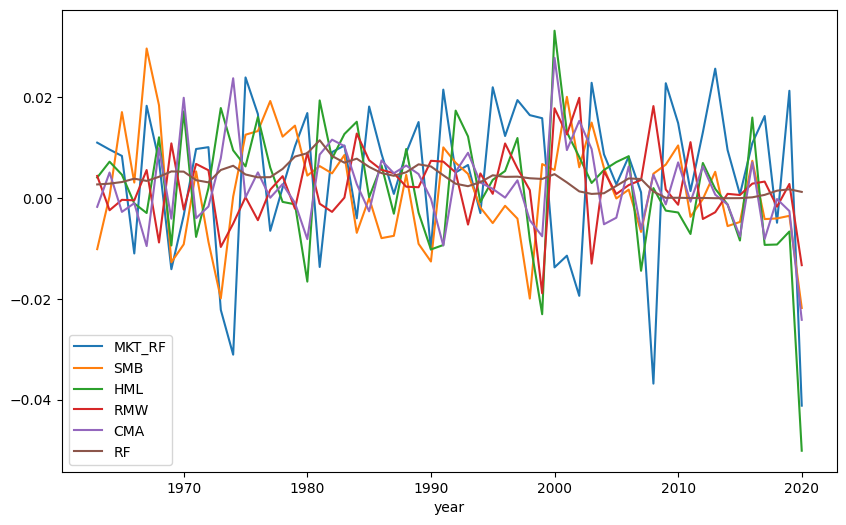

In [38]:
FF_factors.groupby(["year"])[['MKT_RF','SMB','HML','RMW','CMA','RF']].mean().plot(figsize= (10, 6))
plt.legend(loc = "best");

# Fama-Macbeth regressions

## Step1 time-series regression

In [50]:
import statsmodels.api as sm
import pandas as pd

# 1. Use ALL stock IDs from your data_ml file
stock_ids_short = data_ml["stock_id"].unique()

# 2. Filter data_ml to only these stocks (this is redundant but correct)
in_stock_ids_short = data_ml.stock_id.isin(stock_ids_short)

# 3. Select needed columns and merge with FF factors
data_FM = pd.merge(
    data_ml.loc[in_stock_ids_short, ["date", "stock_id", "R1M_Usd"]].reset_index(drop=True),
    FF_factors,
    how="left",
    on="date"
).sort_values(["stock_id", "date"])

# 4. Shift the return by 1 month (lag)
data_FM["R1M_Usd"] = data_FM.groupby("stock_id")["R1M_Usd"].shift(1)

# 5. Drop missing rows caused by shifting or factor alignment
data_FM.dropna(axis=0, inplace=True)
data_FM.reset_index(drop=True, inplace=True)

# 6. Show first + last rows
pd.concat([data_FM.head(), data_FM.tail()])


,date,stock_id,R1M_Usd,MKT_RF,SMB,HML,RMW,CMA,RF,year
0,1998-12-31,1,-0.340,0.0616,-0.0157,-0.0418,-0.0076,-0.0341,0.0038,1998
1,1999-01-31,1,-0.057,0.0350,-0.0073,-0.0462,-0.0279,-0.0678,0.0035,1999
2,1999-02-28,1,-0.352,-0.0408,-0.0520,0.0188,-0.0117,0.0406,0.0035,1999
3,1999-03-31,1,0.494,0.0345,-0.0423,-0.0277,-0.0410,-0.0141,0.0043,1999
4,1999-04-30,1,0.461,0.0433,0.0453,0.0241,-0.0255,0.0093,0.0037,1999
282168,2018-09-30,1212,0.044,0.0006,-0.0250,-0.0170,0.0067,0.0128,0.0015,2018
282169,2018-10-31,1212,-0.266,-0.0768,-0.0450,0.0343,0.0100,0.0354,0.0019,2018
282170,2018-11-30,1212,0.013,0.0169,-0.0076,0.0026,-0.0062,0.0040,0.0018,2018
282171,2018-12-31,1212,-0.125,-0.0955,-0.0291,-0.0190,-0.0003,0.0020,0.0019,2018
282172,2019-01-31,1212,0.222,0.0841,0.0301,-0.0044,-0.0078,-0.0153,0.0021,2019


In [51]:
import statsmodels.api as sm
import pandas as pd
import numpy as np

# 1. Merge factors with returns per-date (already done)
df = data_FM.copy()

# 2. Build pivot table of returns by stock_id × date
returns = df.pivot(index='date', columns='stock_id', values='R1M_Usd')

# 3. Align factors to the same dates as returns
factors = df[['date','MKT_RF','SMB','HML','RMW','CMA']].drop_duplicates()
factors = factors.set_index('date').loc[returns.index]

# 4. Add constant
X = sm.add_constant(factors)

# 5. Run OLS for EACH stock_id
betas = {}

for stock in returns.columns:
    y = returns[stock].dropna()

    # skip stocks with too few observations
    if len(y) < 24:   # require at least 2 years
        continue

    X_sub = X.loc[y.index]

    # must have no missing factor rows
    if X_sub.isna().any().any():
        continue

    model = sm.OLS(endog=y, exog=X_sub).fit()

    betas[stock] = model.params

# 6. Convert to DataFrame
betas = pd.DataFrame(betas).T
betas.index.name = 'stock_id'

# 7. Show first rows
betas.head()


,const,MKT_RF,SMB,HML,RMW,CMA
stock_id,,,,,,
1,0.008154,1.347350,0.549103,0.757947,0.772274,-0.331594
2,0.012286,1.299607,1.011718,-0.512500,-0.616244,-0.722299
3,-0.002448,0.806956,1.018981,0.867583,0.302570,-0.427561
4,0.003162,0.353350,0.319962,-0.041537,0.638692,0.378320
5,0.009832,1.514823,0.764563,0.169622,-0.028818,-0.858341


In [49]:
data_FM = pd.merge(data_FM[['date','MKT_RF','SMB','HML','RMW','CMA','RF']].drop_duplicates(),
                   pd.pivot(data=data_FM, index = 'date', columns='stock_id', values='R1M_Usd'),
                   how='left', on ='date')

factors = sm.add_constant(data_FM[['MKT_RF','SMB','HML','RMW','CMA']])
betas = data_FM.iloc[:, 7:].apply(lambda x: sm.OLS(endog = x, exog = factors).fit().params,
                                  axis=0).T
betas.head()

,const,MKT_RF,SMB,HML,RMW,CMA
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.002448,0.806956,1.018981,0.867583,0.302570,-0.427561
4,0.003162,0.353350,0.319962,-0.041537,0.638692,0.378320
5,NaN,NaN,NaN,NaN,NaN,NaN


## Step2: cross-section regression

In [63]:
FM_data = pd.merge(betas.iloc[:, 1:], returns.T, how = "left",
                   left_index = True, right_index=True)
FM_data.head()

,MKT_RF,SMB,HML,RMW,CMA,1998-12-31,1999-01-31,1999-02-28,1999-03-31,1999-04-30,...,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31
stock_id,,,,,,,,,,,,,,,,,,,,,
1,1.347350,0.549103,0.757947,0.772274,-0.331594,-0.340,-0.057,-0.352,0.494,0.461,...,-0.038,0.000,-0.077,-0.002,-0.155,0.014,-0.110,0.082,NaN,NaN
2,1.299607,1.011718,-0.512500,-0.616244,-0.722299,0.646,0.111,-0.471,-0.098,NaN,...,-0.031,-0.021,-0.031,-0.009,-0.044,-0.136,-0.079,0.090,NaN,NaN
3,0.806956,1.018981,0.867583,0.302570,-0.427561,0.016,-0.028,0.004,-0.060,0.071,...,-0.028,-0.039,0.033,-0.049,-0.070,0.036,-0.070,0.030,0.046,-0.046
4,0.353350,0.319962,-0.041537,0.638692,0.378320,-0.088,-0.081,0.041,-0.106,0.070,...,0.059,0.029,-0.004,0.036,-0.025,0.000,-0.088,0.043,0.050,0.022
5,1.514823,0.764563,0.169622,-0.028818,-0.858341,NaN,NaN,NaN,NaN,NaN,...,0.013,-0.020,0.202,0.015,-0.172,0.147,NaN,NaN,NaN,NaN


In [64]:
gammas_list = []

for date in R.index:

    y = R.loc[date].dropna()
    y = y[y.index.isin(B.index)]

    if len(y) < 10:
        continue

    X = B.loc[y.index]
    X = sm.add_constant(X)

    model = sm.OLS(y, X).fit()

    row_dict = model.params.to_dict()
    row_dict['date'] = date

    gammas_list.append(row_dict)

gammas = pd.DataFrame(gammas_list).set_index('date')
gammas.head()


,const,MKT_RF,SMB,HML,RMW,CMA
date,,,,,,
1998-12-31,-0.918157,0.052934,-0.018608,-0.064178,-0.023774,-0.054803
1999-01-31,0.626813,0.036547,0.000189,-0.045355,-0.048123,-0.076788
1999-02-28,1.299489,-0.017826,-0.017453,0.046484,0.016355,0.047744
1999-03-31,0.086270,0.051231,-0.036685,-0.005930,-0.005956,-0.024586
1999-04-30,-0.076048,0.064317,0.003682,0.018963,-0.004245,-0.012352


In [66]:
gammas_list = []

for date in returns_filtered.index:

    # returns at month t
    y = returns_filtered.loc[date].dropna()

    # keep only stocks with valid betas
    y = y[y.index.isin(betas.index)]

    if len(y) < 10:
        continue

    # betas for these stocks
    X = betas.loc[y.index]
    X = sm.add_constant(X)

    # regression
    model = sm.OLS(y, X).fit()

    # store gamma_t
    gammas_list.append({
        'date': date,
        **model.params.to_dict()
    })

gammas = pd.DataFrame(gammas_list).set_index('date')
gammas.head()


,const,MKT_RF,SMB,HML,RMW,CMA
date,,,,,,
1998-12-31,-0.918157,0.052934,-0.018608,-0.064178,-0.023774,-0.054803
1999-01-31,0.626813,0.036547,0.000189,-0.045355,-0.048123,-0.076788
1999-02-28,1.299489,-0.017826,-0.017453,0.046484,0.016355,0.047744
1999-03-31,0.086270,0.051231,-0.036685,-0.005930,-0.005956,-0.024586
1999-04-30,-0.076048,0.064317,0.003682,0.018963,-0.004245,-0.012352


/usr/local/lib/python3.12/dist-packages/matplotlib/ticker.py:296: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return self.seq[pos]


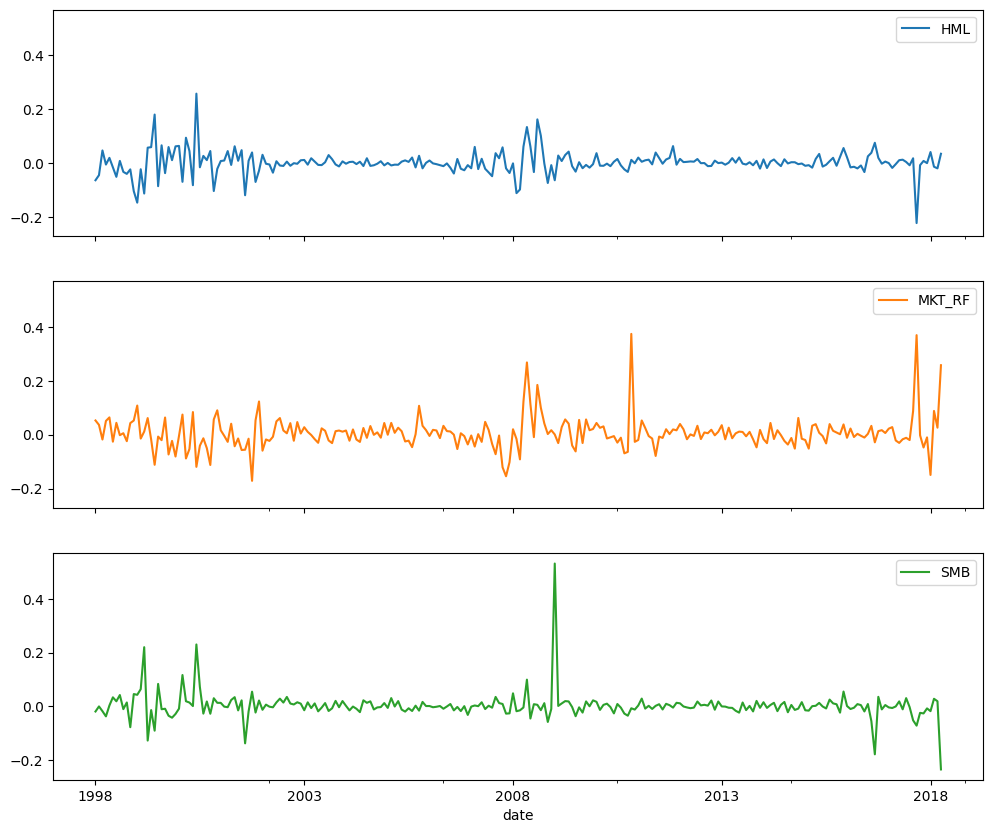

In [67]:
import matplotlib.ticker as mticker

gammas.loc[:, ['HML','MKT_RF','SMB',]].plot(figsize=(12,10),
                                           subplots=True, sharey=True, sharex=True);
ax = plt.gca()
skip = 60
gammas['date'] = pd.to_datetime(gammas.index)
ticklabels = gammas['date'].dt.strftime('%Y')[::skip]
ax.set_xticks(range(gammas.shape[0])[::skip])
ax.xaxis.set_major_formatter(mticker.FixedFormatter(ticklabels));

# Redundant factors (HML in FF5)

In [68]:
factors = ["MKT_RF", "SMB", "HML", "RMW", "CMA"]
FF_factors = FF_factors.loc[:, factors]

models = FF_factors.apply(lambda x: sm.OLS(endog=FF_factors.loc[:, FF_factors.columns == x.name],
                          exog=sm.add_constant(FF_factors.loc[:, FF_factors.columns != x.name])).fit(),
                          axis=0)

alphas = pd.DataFrame({"const":map(lambda x: x.params["const"], models),
                        "p_value":map(lambda x: x.pvalues["const"], models)},
                       index = factors)
alphas

,const,p_value
MKT_RF,0.007795,3.728560e-07
SMB,0.002731,1.326845e-02
HML,-0.000590,4.627031e-01
RMW,0.003867,9.461697e-07
CMA,0.002403,5.425026e-06


In [70]:
stars = ['(***)','(**)','(*)','','']

df_significance = pd.DataFrame(
    map(lambda x: x.pvalues, models),
    index=factors
).loc[:, ["const"] + factors]

conditions = [
    (df_significance > 0) & (df_significance < 0.001),
    (df_significance >= 0.001) & (df_significance < 0.01),
    (df_significance >= 0.01) & (df_significance < 0.05),
    (df_significance >= 0.05),
    (df_significance.isna())
]

df_significance = pd.DataFrame(
    np.select(conditions, stars, default="").astype(str),
    index=factors
)

df_significance.columns = ["const"] + factors
df_significance


,const,MKT_RF,SMB,HML,RMW,CMA
MKT_RF,(***),,(***),,(***),(***)
SMB,(*),(***),,,(***),
HML,,,,,(***),(***)
RMW,(***),(***),(***),(***),,(***)
CMA,(***),(***),,(***),(***),


In [71]:
df_coef = pd.DataFrame(map(lambda x: x.params, models),
                       index = factors).loc[:, ["const"] + factors]
df_coef = round(df_coef,3).astype(str)
df_coef.apply(lambda x: x.str.cat(df_significance[x.name]),axis=0)

,const,MKT_RF,SMB,HML,RMW,CMA
MKT_RF,0.008(***),nan,0.258(***),0.121,-0.359(***),-0.946(***)
SMB,0.003(*),0.131(***),nan,0.082,-0.434(***),-0.134
HML,-0.001,0.033,0.043,nan,0.171(***),1.027(***)
RMW,0.004(***),-0.095(***),-0.225(***),0.168(***),nan,-0.315(***)
CMA,0.002(***),-0.112(***),-0.031,0.451(***),-0.141(***),nan


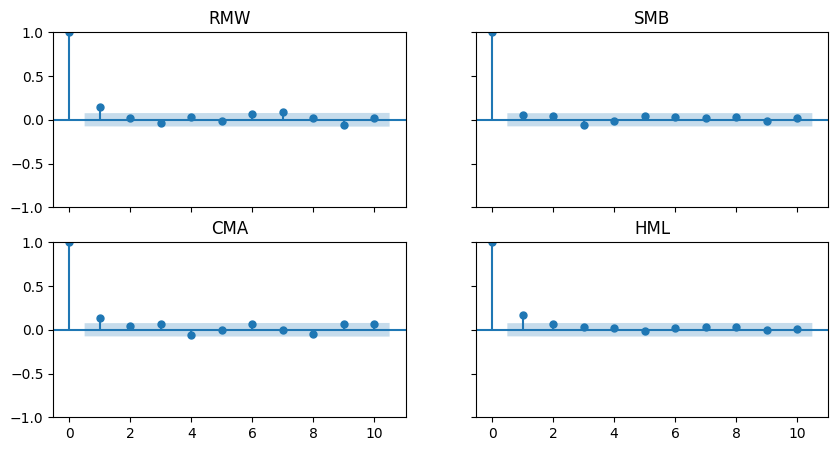

In [72]:
fig, ax = plt.subplots(2,2,figsize=(10,5),sharex='all', sharey='all')
sm.graphics.tsa.plot_acf(FF_factors[['RMW']], lags=10, ax=ax[0,0],title='RMW')
sm.graphics.tsa.plot_acf(FF_factors[['CMA']], lags=10, ax=ax[1,0],title='CMA')
sm.graphics.tsa.plot_acf(FF_factors[['SMB']], lags=10, ax=ax[0,1],title='SMB')
sm.graphics.tsa.plot_acf(FF_factors[['HML']], lags=10, ax=ax[1,1],title='HML');

# Coding Exercises

## 1

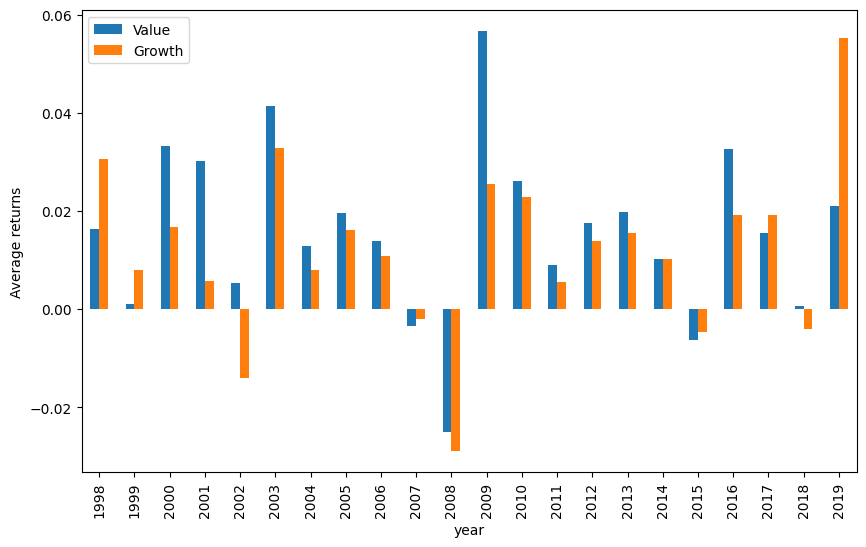

In [73]:
_median = data_ml[["date", "Pb"]].groupby(["date"]).median().reset_index()
_median.rename(columns = {'Pb': 'Pb_median'}, inplace = True)
data_tmp = pd.merge(data_ml[["date", "R1M_Usd", "Pb"]], _median,
                    how = "left", on = ["date"])
data_tmp["growth"] = np.where(data_tmp["Pb"] > data_tmp["Pb_median"], "Growth", "Value")
data_tmp["year"] = pd.to_datetime(data_tmp['date']).dt.year
data_tmp = data_tmp.groupby(["year", "growth"])["R1M_Usd"].mean().unstack()
data_tmp.loc[:, ["Value","Growth"]].plot.bar(figsize = (10, 6));
plt.ylabel('Average returns')
plt.xlabel('year')
plt.legend(loc = "best");

## 2

/usr/local/lib/python3.12/dist-packages/matplotlib/ticker.py:296: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return self.seq[pos]


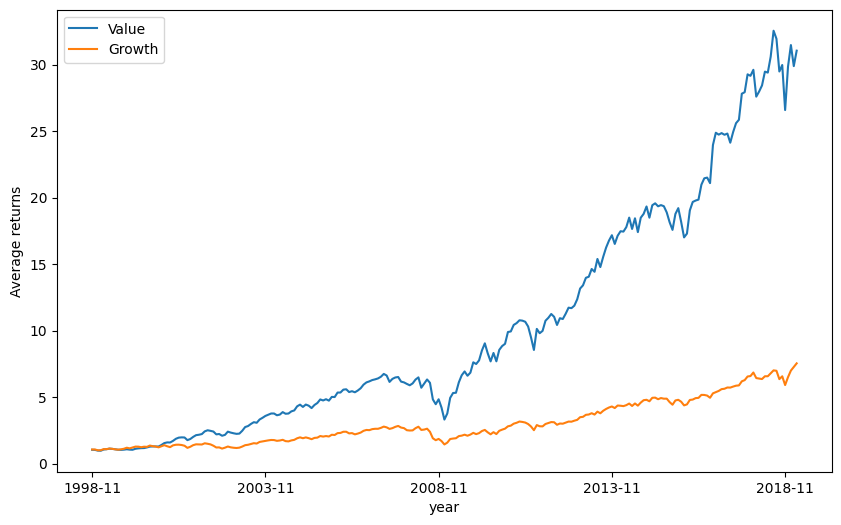

In [74]:
_median = data_ml[["date", "Pb"]].groupby(["date"]).median().reset_index()
_median.rename(columns = {'Pb': 'Pb_median'}, inplace = True)
data_tmp = pd.merge(data_ml[["date", "R1M_Usd", "Pb"]], _median,
                    how = "left", on = ["date"])
data_tmp["growth"] = np.where(data_tmp["Pb"] > data_tmp["Pb_median"], "Growth", "Value")
data_tmp = data_tmp.groupby(["date", "growth"])["R1M_Usd"].mean().unstack()
(1+data_tmp.loc[:, ["Value", "Growth"]]).cumprod().plot(figsize = (10, 6));
plt.ylabel('Average returns')
plt.xlabel('year')
plt.legend(loc = "best");

ax = plt.gca()
skip = 60;
data_tmp['date'] = pd.to_datetime(data_tmp.index)
ticklabels = data_tmp['date'].dt.strftime('%Y-%m')[::skip]
ax.set_xticks(range(data_tmp.shape[0])[::skip])
ax.xaxis.set_major_formatter(mticker.FixedFormatter(ticklabels));

## 3

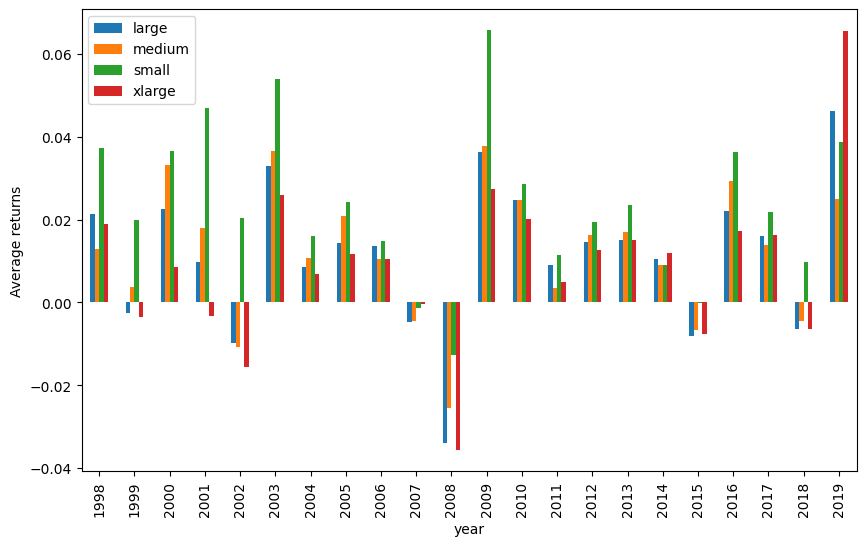

In [77]:
values = ["small", "medium", "large", "xlarge"]

conditions = [
    data_ml["Mkt_Cap_6M_Usd"] <= 0.25,
    (data_ml["Mkt_Cap_6M_Usd"] > 0.25) & (data_ml["Mkt_Cap_6M_Usd"] <= 0.5),
    (data_ml["Mkt_Cap_6M_Usd"] > 0.5) & (data_ml["Mkt_Cap_6M_Usd"] <= 0.75),
    data_ml["Mkt_Cap_6M_Usd"] > 0.75
]

data_tmp = data_ml[["date", "R1M_Usd", "Mkt_Cap_6M_Usd"]].copy()

# FIX: provide a string default
data_tmp["Mkt_cap_quartile"] = np.select(conditions, values, default="unknown")

data_tmp["year"] = pd.to_datetime(data_tmp['date']).dt.year

data_tmp = (
    data_tmp.groupby(["year", "Mkt_cap_quartile"])["R1M_Usd"]
    .mean()
    .unstack()
)

data_tmp.loc[:, ["large", "medium", "small", "xlarge"]].plot.bar(figsize=(10, 6))
plt.ylabel('Average returns')
plt.xlabel('year')
plt.legend(loc="best")
